In [1]:
import numpy as np
import scipy.signal
import torch
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from collections import Counter
import torchaudio
import itertools
import tqdm
import torch.nn.functional as F
import scipy as sp
import torch.nn as nn
import fb
import pickle

In [41]:
HYPERPARAMS = {
    "synth": {
        "N": 4092,
        "J": 58,
        "T": 1024,
        "sr": 16000,
        "fmin": 64,
        "fmax": 8000,
        "batch_size": 64
    },
    "speech": { # this is for MEL
        "N": 4095, # 4096 for GAM
        "J": 42, # 67 for GAM
        "T": 1024,
        "sr": 16000,
        "fmin": 45,
        "fmax": 8000,
        "batch_size": 64
    },
    "music": {
        "N": 2**12,
        "J": 96,
        "T": 1024,
        "sr": 16000,
        "fmin": 64,
        "fmax": 8000,
        "batch_size": 64
    },
}

In [42]:
spec = HYPERPARAMS["synth"]

In [43]:
# load the info about the target fb as dictionaries, containing:
#   "freqz" frequency responses as 2D array (time,channels)
#   "centerfreq" 
#   "bandwidths"
#   "framebounds" computed without subsampling

with open('Target Filterbanks/CQT/CQT.pkl', 'rb') as fp:
    CQT = pickle.load(fp)

with open('Target Filterbanks/CQT/CQT_toy.pkl', 'rb') as fp:
    CQT_toy = pickle.load(fp)

with open('Target Filterbanks/Gammatone/GAM.pkl', 'rb') as fp:
    GAM = pickle.load(fp)

with open('Target Filterbanks/Mel/MEL.pkl', 'rb') as fp:
    MEL = pickle.load(fp)

with open('Target Filterbanks/VQT/VQT.pkl', 'rb') as fp:
    VQT = pickle.load(fp)

CQT_freq = CQT["freqz"]
CQT_torch = torch.from_numpy(CQT_freq.T)

CQT_toy_freq = CQT_toy["freqz"]
CQT_toy_torch = torch.from_numpy(CQT_toy_freq.T)

GAM_freq = GAM["freqz"]
GAM_torch = torch.from_numpy(GAM_freq.T)

MEL_freq = MEL["freqz"]
MEL_torch = torch.from_numpy(MEL_freq.T)

VQT_freq = VQT["freqz"]
VQT_torch = torch.from_numpy(VQT_freq.T)

In [44]:
CQT_torch.shape

torch.Size([58, 4092])

In [45]:
# load the filters from the other notebook

load_filters = False

if load_filters:
    w_init = np.load('w_init.npy')
    w_tight = np.load('w_tight_fir.npy')
    w_init = torch.from_numpy(w_init)
    w_tight = torch.from_numpy(w_tight)
else:
    w_init = fb.random_filterbank(spec["N"], spec["J"], spec["T"], tight=False, to_torch=True, support_only=True)

In [46]:
# N = 1024
# T = 32
# J = 10
# w_init, w_tight = fb.random_filterbank(N, J, T, tight=True, to_torch=False, support_only=False)
# W = w_init

# Gam = np.eye(N)/N
# for _ in range(10):
#     Gam = sum([np.outer(W[j,:],W[j,:]) / np.matmul(W[j,:],np.matmul(Gam,W[j,:])) for j in range(J)])
#     Gam = Gam / np.trace(Gam)


In [47]:
# Gam_sq = sp.linalg.sqrtm(Gam)
# w_tight_Gam = np.matmul(Gam_sq,w_init.T).T
# A,B = fb.frame_bounds_lp(w_tight_Gam)
# B/A

In [48]:
synth = fb.generate_random_sine(
    spec["sr"],
    spec["fmin"],
    spec["fmax"],
    spec["N"],
    spec["batch_size"])

In [52]:
def filterbank_response_fft(x, w):
    # some shaping
    x = x.reshape(x.shape[0], 1, x.shape[-1])
    w = w.unsqueeze(0).float()
    Wx = torch.fft.ifft(torch.fft.fft(x, dim=-1) * w, dim=-1)
    Wx = torch.abs(Wx)
    phi = torch.ones(spec["J"], spec["J"], spec["T"])
    Ux = F.conv1d(Wx, phi, bias=None, stride=256, padding=0)
    return Ux

In [53]:
# conv1D layer with circulant boundary conditions

class TDFilterbank_real(torch.nn.Module):
    def __init__(self, spec, w):
        super().__init__()
        
        self.psi = torch.nn.Conv1d(
            in_channels=1,
            out_channels=spec["J"],
            kernel_size=spec["T"],
            stride=1,
            padding=0,
            bias=False)

        self.psi.weight.data = w[:, :spec["T"]].unsqueeze(1).float()        
    
    def forward(self, x):
        x = x.reshape(x.shape[0], 1, x.shape[-1])
        x = F.pad(x, (0, spec["T"]-1), mode='circular',)
        Wx = torch.abs(self.psi(x))
        # Wx_imag = self.psi_imag(x)
        # Ux = (Wx_real*Wx_real + Wx_imag*Wx_imag)
        phi = torch.ones(spec["J"], spec["J"], spec["T"])
        Ux = F.conv1d(Wx, phi, bias=None, stride=256, padding=0)
        return Ux
    
baseline = TDFilterbank_real(spec, w_init)
print(baseline)

TDFilterbank_real(
  (psi): Conv1d(1, 58, kernel_size=(1024,), stride=(1,), bias=False)
)


In [54]:
# check output sizes
filterbank_response_fft(next(synth), CQT_torch).shape, baseline(next(synth)).shape

(torch.Size([64, 58, 12]), torch.Size([64, 58, 12]))

In [63]:
# loss function penalizing kappa and cosine similarity

class KappaLoss(nn.Module):
    def __init__(self):
        super(KappaLoss, self).__init__()
        self.loss = nn.CosineSimilarity(dim=0)

    def forward(self, inputs, targets, w, beta):
        w_hat = torch.sum(torch.abs(torch.fft.fft(w,dim=1))**2,dim=0)
        B = torch.max(w_hat,dim=0).values
        A = torch.min(w_hat,dim=0).values
        loss = 0.5*torch.mean(1-self.loss(inputs, targets)) + beta*B/A
        return loss

In [64]:
# training function

def train(baseline, penalization, lr, beta, n_epochs, epoch_size):
    optimizer = torch.optim.Adam(baseline.parameters(), lr=lr)
    cos = torch.nn.CosineSimilarity(dim=0)
    criterion = KappaLoss()
    if penalization == 'cos':
        beta=0
    if penalization == 'kappa':
        beta=beta
    losses = []
    conditions = []

    running_loss = 0.0
    for _ in range(epoch_size):
        inputs = next(synth)
        outputs = baseline(inputs)
        targets = filterbank_response_fft(inputs, CQT_torch)
        loss = 0.5*torch.mean(1-cos(outputs, targets))
        running_loss += loss.item()
    print(1000 * running_loss)

    w = baseline.psi.weight.detach().numpy()[:,0,:]
    w = np.pad(w, ((0,0),(0, spec["N"]-spec["T"])), constant_values=0)
    A,B = fb.frame_bounds_lp(w)
    conditions.append(B/A)
    
    losses.append(running_loss)

    for _ in range(n_epochs):
        running_loss = 0.0
        for i in tqdm.tqdm(range(epoch_size)):
            inputs = next(synth)
            optimizer.zero_grad()
            outputs = baseline(inputs)
            targets = filterbank_response_fft(inputs, CQT_torch)

            w = baseline.psi.weight[:,0,:]
            w = F.pad(w,(0,spec["N"]-spec["T"]), value=0)
            loss = criterion(outputs, targets, w, beta)

            loss.backward()
            optimizer.step()

            loss2 = 0.5*torch.mean(1-cos(outputs, targets))
            running_loss += loss2.item()
        losses.append(running_loss)

        w = baseline.psi.weight.detach().numpy()[:,0,:]
        w = np.pad(w, ((0,0),(0, spec["N"]-spec["T"])), constant_values=0)
        A,B = fb.frame_bounds_lp(w)
        conditions.append(B/A)

        print(1000 * running_loss)

    return losses, conditions

In [90]:
w = baseline.psi.weight[:,0,:]
F.pad(w,(0,spec["N"]-spec["T"]), value=0).shape

torch.Size([58, 4092])

In [83]:
n_epochs = 1
epoch_size = 20
lr = 1e-4
beta = 0.001

baseline = TDFilterbank_real(spec, w_init)
losses_mse, conditions_mse = train(
    baseline=baseline,
    penalization='cos',
    lr=lr,
    beta=beta,
    n_epochs=n_epochs,
    epoch_size=epoch_size)

w_no = baseline.psi.weight.detach().numpy()[:,0,:]

baseline = TDFilterbank_real(spec, w_init)
losses_kappa, conditions_kappa = train(
    baseline=baseline,
    penalization='kappa',
    lr=lr,
    beta=beta,
    n_epochs=n_epochs,
    epoch_size=epoch_size)

w_kappa = baseline.psi.weight.detach().numpy()[:,0,:]

# baseline = TDFilterbank_real(spec, w_tight)
# losses_tight, conditions_tight = train(
#     baseline=baseline,
#     penalization='kappa',
#     lr=lr,
#     n_epochs=n_epochs,
#     epoch_size=epoch_size)

# w_tight = baseline.psi.weight.detach().numpy()[:,0,:]

153.90390669927


100%|██████████| 20/20 [00:54<00:00,  2.72s/it]


100.3074049949646
156.69826557859778


100%|██████████| 20/20 [00:58<00:00,  2.91s/it]

99.3608171120286


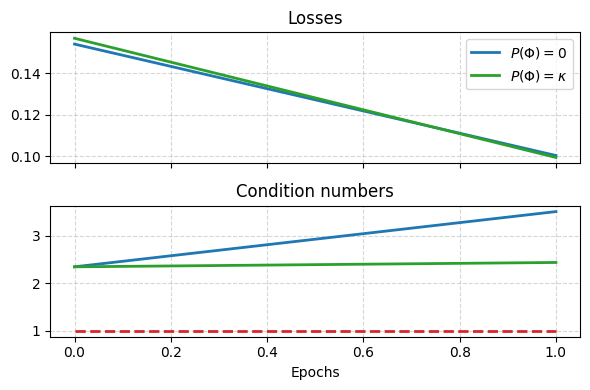

In [85]:
# plot losses and condition numbers over epochs

plt.rcParams['text.usetex'] = False

fig, axes = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
Ts = np.arange(0, n_epochs+1)

ax = axes[0]
ax.plot(Ts, losses_mse, 'tab:blue', linewidth=2, label='$P(\Phi)=0$')
ax.plot(Ts, losses_kappa, 'tab:green', linewidth=2, label='$P(\Phi)=\kappa$')
# ax.plot(Ts, losses_tight, 'tab:orange', linewidth=2, marker = 's', label='$P(\Phi)=\kappa$ + tightening')

ax.set_title('Losses')
ax.grid(linestyle='--', alpha=0.5)

ax = axes[1]
ax.plot(Ts, conditions_mse, 'tab:blue', linewidth=2)
ax.plot(Ts, conditions_kappa, 'tab:green', linewidth=2)
# ax.plot(Ts, conditions_tight, 'tab:orange', linewidth=2, marker = 's')
ax.plot(Ts, np.ones(len(Ts)), 'tab:red', linewidth=2, label='Tightened', linestyle='--')

ax.set_title('Condition numbers')
ax.set_xlabel('Epochs')
axes[0].legend(loc='upper right')
ax.grid(linestyle='--', alpha=0.5)

plt.tight_layout()

plt.savefig('Fitting_Tight_Filterbanks.pdf', bbox_inches='tight')

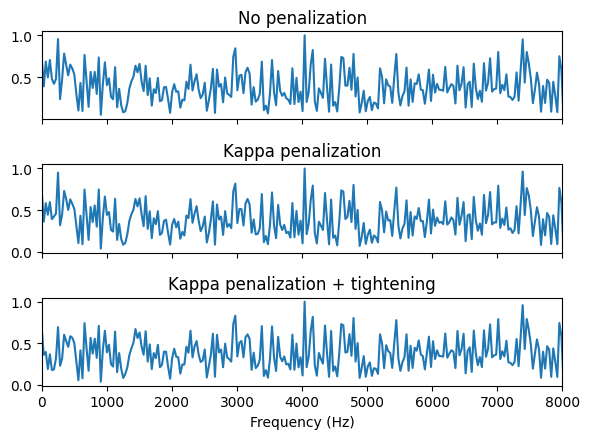

In [130]:
plt.rcParams['text.usetex'] = False

w_no_hat = np.fft.fft(w_no, axis=1).T
w_kappa_hat = np.fft.fft(w_kappa, axis=1).T
w_tight_hat = np.fft.fft(w_init, axis=1).T

w_no_abs = np.abs(w_no_hat)/np.max(np.abs(w_no_hat), axis=0)
w_kappa_abs = np.abs(w_kappa_hat)/np.max(np.abs(w_kappa_hat), axis=0)
w_tight_abs = np.abs(w_tight_hat)/np.max(np.abs(w_tight_hat), axis=0)

fig, axes = plt.subplots(3, 1, figsize=(6, 4.5), sharex=True)

omega = np.linspace(0, spec["sr"], w_no.shape[1])

ax = axes[0]
ax.plot(omega, w_no_abs[:,30])
ax.set_title('No penalization')
ax.set_xlim(0, spec["sr"]//2+1)

ax = axes[1]
ax.plot(omega, w_kappa_abs[:,30])
ax.set_title('Kappa penalization')
ax.set_xlim(0, spec["sr"]//2+1)

ax = axes[2]
ax.plot(omega, w_tight_abs[:,30])
ax.set_title('Kappa penalization + tightening')
ax.set_xlim(0, spec["sr"]//2+1)

ax.set_xlabel('Frequency (Hz)')

plt.tight_layout()

plt.savefig('Filterbank_Responses.pdf', bbox_inches='tight')

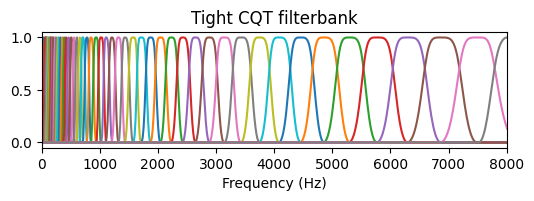

In [425]:
fig = plt.figure(figsize=(6, 1.5))

omega = np.linspace(0, spec["sr"], CQT_freq.shape[0])
plt.plot(omega, CQT_freq/ np.max(CQT_freq, axis=0));
plt.title("Tight CQT filterbank")
plt.xlim(0, spec["sr"]//2+1)
plt.xlabel("Frequency (Hz)");

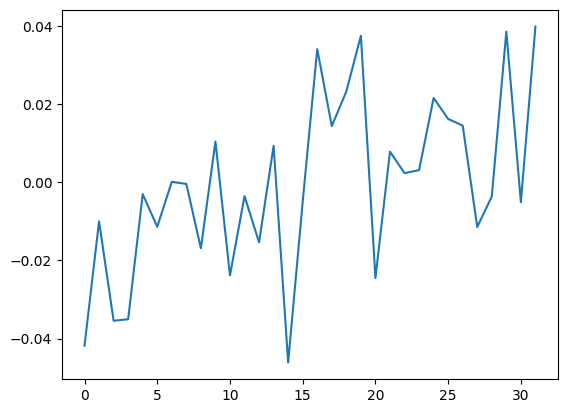

In [490]:
plt.plot(w[50,:])